In [1]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import sys

print('CWD:', Path.cwd())

# Discover eval JSONs by checking current directory and its parents
candidates = []
for base in [Path.cwd()] + list(Path.cwd().parents):
    d = base / 'outputs' / 'evals'
    if d.exists():
        candidates.extend(sorted(d.glob('*.json')))
# Fallback: search recursively under current working directory (less preferred)
if not candidates:
    candidates = list(Path.cwd().rglob('outputs/evals/*.json'))

if not candidates:
    print('No evaluation JSON files found under outputs/evals (searched workspace).')
    print('Make sure you run the evaluation or place result files under outputs/evals.')

data = {}
for p in candidates:
    fname = p.name.lower()
    # Map filenames to friendly experiment keys
    if 'baseline' in fname:
        key = 'baseline'
    elif 'hybrid' in fname:
        key = 'hybrid'
    elif 'gsm8k' in fname and 'baseline' not in fname and 'hybrid' not in fname:
        key = 'gsm8k'
    else:
        key = p.stem

    print('Loading', p, 'as', key)
    try:
        raw = json.loads(p.read_text(encoding='utf-8'))
    except Exception as e:
        print(f'Failed to read {p}:', e, file=sys.stderr)
        continue

    # Extract nested metrics dict if present, e.g. {'gsm8k': {...}}
    if isinstance(raw, dict) and len(raw) == 1 and isinstance(next(iter(raw.values())), dict):
        metrics = next(iter(raw.values()))
    else:
        metrics = raw.get('gsm8k', raw)

    data[key] = metrics

# Build dataframe and validate expected columns
if not data:
    df = pd.DataFrame()
    print('No valid eval data loaded.')
else:
    df = pd.DataFrame(data).T
    df.index.name = 'experiment'
    expected = ['accuracy','self_consistency','acknowledgement_rate']
    missing_cols = [c for c in expected if c not in df.columns]
    if missing_cols:
        print('Missing expected metric columns:', missing_cols)
        print('Available columns per experiment:')
        print(df.to_dict(orient='index'))
    else:
        df = df[expected]

df

CWD: /home/DAVIDSON/munikzad/csc224n/reasoning/notebooks
Loading /home/DAVIDSON/munikzad/csc224n/reasoning/outputs/evals/eval_gsm8k.json as gsm8k
Loading /home/DAVIDSON/munikzad/csc224n/reasoning/outputs/evals/eval_gsm8k_baseline.json as baseline
Loading /home/DAVIDSON/munikzad/csc224n/reasoning/outputs/evals/eval_gsm8k_hybrid.json as hybrid
Loading /home/DAVIDSON/munikzad/csc224n/reasoning/outputs/evals/gsm8k_samples_detailed.json as gsm8k
Loading /home/DAVIDSON/munikzad/csc224n/reasoning/outputs/evals/gsm8k_samples_summary.json as gsm8k


,accuracy,self_consistency,acknowledgement_rate
experiment,,,
gsm8k,NaN,NaN,NaN
baseline,0.8,0.75,0.6
hybrid,0.81,0.73,0.947368


Saved outputs/figures/accuracy_comparison.png


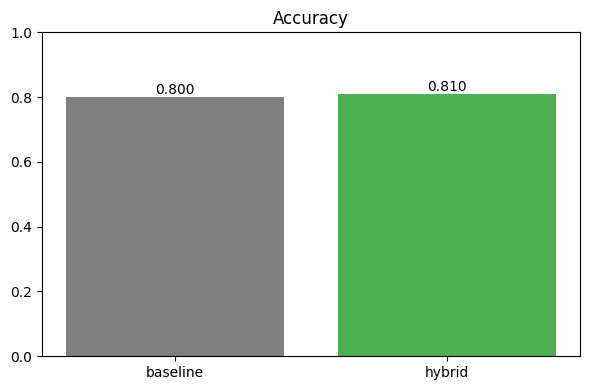

Saved outputs/figures/self_consistency_comparison.png


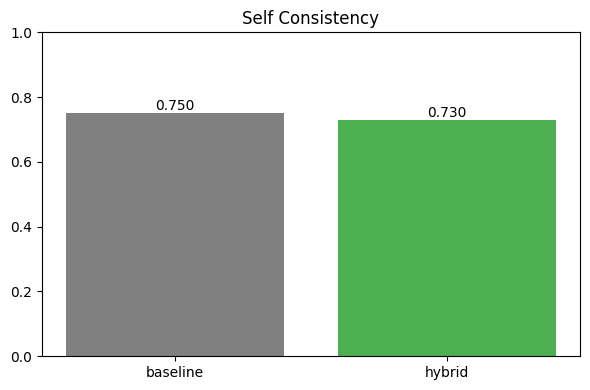

Saved outputs/figures/acknowledgement_rate_comparison.png


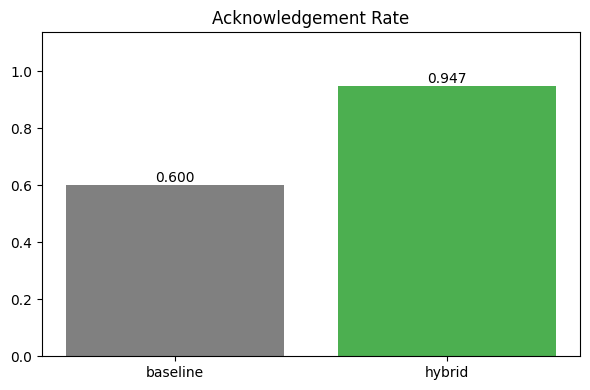

In [3]:
# Simple bar charts for each metric
output_dir = Path('outputs/figures')
output_dir.mkdir(parents=True, exist_ok=True)

if df.empty:
    print('No data to plot. Load evaluation JSONs first.')
else:
    metrics = ['accuracy','self_consistency','acknowledgement_rate']
    colors = {'baseline':'#808080','gsm8k':'#2196F3','hybrid':'#4CAF50'}
    for metric in metrics:
        if metric not in df.columns:
            print(f'Skipping {metric}: not in dataframe columns')
            continue
        plt.figure(figsize=(6,4))
        vals = df[metric]
        bars = plt.bar(vals.index, vals.values, color=[colors.get(i,'#666666') for i in vals.index])
        plt.title(metric.replace('_',' ').title())
        plt.ylim(0, max(vals.max()*1.2, 1.0))
        for bar, val in zip(bars, vals.values):
            plt.text(bar.get_x()+bar.get_width()/2, val + 0.01, f'{val:.3f}', ha='center')
        plt.tight_layout()
        out_path = output_dir / f'{metric}_comparison.png'
        plt.savefig(out_path, dpi=150)
        print('Saved', out_path)
        plt.show()
